# AD Model Inference

## Create Project

In [1]:
import mlrun

> 2022-06-14 18:08:57,797 [info] Server and client versions are not the same: {'parsed_server_version': VersionInfo(major=1, minor=1, patch=0, prerelease='rc3', build=None), 'parsed_client_version': VersionInfo(major=1, minor=0, patch=2, prerelease=None, build=None)}


In [2]:
# Set the project name:
project_name = "inference-pipeline"

# Create the project:
project = mlrun.get_or_create_project(name=project_name, context="./", user_project=True)

> 2022-06-14 18:09:07,815 [info] loaded project inference-pipeline from MLRun DB


In [3]:
framework = "tf-keras"

## Upload pre-trained model

In [4]:
# mlrun:start-code

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 19:58:29 2022

@author: 105050802
"""

import json
import joblib
from typing import Dict, List

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import mlrun
from mlrun.frameworks.sklearn import apply_mlrun
import mlrun.frameworks.tf_keras as mlrun_tf_keras
import shutil

class ModelHelper:
    
    @classmethod
    def convert_json_to_pd_series(cls,
                                  json_string: str,
                                  data_contains_status: bool) -> List[pd.Series]:

        result_data = []
        try:
            json_dict = json.loads(json_string)
        except json.JSONDecodeError:
            cls._logger.exception(
                'Could not parse data to convert to Pandas series.')
            return result_data
        col_names = [*json_dict]

        for _, col_name in enumerate(col_names):
            col_values = []
            col_timestamps = []
            col_status_values = []
            col_data = json_dict[col_name]['data']
            for data in col_data:
                col_values.append(data['val'])
                col_timestamps.append(int((data['ts'] * 1000) + 0.01)) # converting to ms
                if data_contains_status:
                    col_status_values.append(data['status'])
            col_timestamps = pd.to_datetime(col_timestamps,
                                            unit='ms', utc=True)
            col_series = pd.Series(col_values,
                                   index=col_timestamps,
                                   name=col_name)
            if pd.api.types.is_numeric_dtype(col_series) is False:
                raise ValueError(
                    f'ModelHelper: Cannot convert {col_name} value to numeric')

            result_data.append(col_series.replace('', np.nan))
            if data_contains_status:
                col_series = pd.Series(col_status_values,
                                       index=col_timestamps,
                                       name=f'{col_name}_status')
                result_data.append(col_series.replace('', np.nan))
        return result_data
    
    @staticmethod
    def convert_pd_series_list_to_df(series_list: List[pd.Series]) -> pd.DataFrame:
        return pd.concat(series_list, axis=1)
    
    @staticmethod
    def convert_df_to_json(result_df: pd.DataFrame):
        results = {}
        timestamps = result_df.index.view('int64') / 1_000_000_000
        col_names = result_df.columns[~result_df.columns.str.contains('_status')]
        for col_name in col_names:
            data = []
            col_status_exists = False
            if col_name+'_status' in result_df.columns:
                col_status_exists = True
            for i, val in enumerate(result_df[col_name]):
                if np.isnan(val):
                    continue
                result = {'ts': timestamps[i], 'val': val}
                if col_status_exists:
                    result['status'] = int(result_df[col_name+'_status'][i])
                data.append(result)
            results[col_name] = {'data': data}
        return json.dumps(results)


class DummyAD:
    
    def __init__(self):
        self._model = None
        self._scaler = None
    
    def train_model(self, json_string: str,context: mlrun.MLClientCtx):
        pd_series = ModelHelper.convert_json_to_pd_series(json_string, False)
        data_df = ModelHelper.convert_pd_series_list_to_df(pd_series)
        data_df.ffill(inplace=True)
        data_df.dropna(inplace=True)
        if data_df.shape[0] < 100:
            raise ValueError('Too short training data.')
        no_tags = data_df.shape[1]
        train_set, test_set = train_test_split(data_df, test_size=0.2)
        
        scaler = StandardScaler()
        train_set = scaler.fit_transform(train_set.values)
        self._scaler = scaler
        
        model = Sequential()
        
        model.add(Dense(no_tags/2, input_dim=no_tags, activation='relu'))
        model.add(Dense(no_tags, activation='linear'))
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    
        model.fit(train_set, 
                  train_set,
                  epochs=2,
                  batch_size=32)
        
        
        self._model = model
        
    def export_model(self,
                     path: str):
        if self._model is None:
            raise ValueError('Model not trained.')
        self._model.save('./model/ad_model')
        state = {'scaler': self._scaler}
        joblib.dump(state, f'{path}/model/ad_state.joblib')

def handler(context:mlrun.MLClientCtx):
    df = pd.DataFrame(np.random.randint(0,100,size=(150, 3)),
                      columns=list('ABC'),
                      index = pd.date_range('2020-01-01', periods=150, freq='5T'))
    for col in df:
        df.loc[df.sample(frac=0.2).index, col] = np.nan
    df_json = ModelHelper.convert_df_to_json(df)
    model = DummyAD()
    model.train_model(df_json,context)
    model.export_model('.')
    
    # Saved as ZIP file
    shutil.make_archive('./model_zip/ad_model_zip', 'zip', './model/ad_model')
    context.log_model('ad_model',model_file='./model_zip/ad_model_zip.zip')
    
    # log joblib model
    context.log_model(key='ad_state',model_dir='./model',model_file='ad_state.joblib')

In [6]:
# mlrun:end-code

In [7]:
train_model = mlrun.code_to_function(
    name="train_model",
    kind="job", 
    image="mlrun/ml-models"
)
train_model.apply(mlrun.platforms.auto_mount())

In [8]:
import json

# data={"A": {"data": [{"ts": 1577836800.0, "val": 61.0}, {"ts": 1577837100.0, "val": 16.0}, {"ts": 1577837400.0, "val": 12.0}, {"ts": 1577837700.0, "val": 26.0}, {"ts": 1577838000.0, "val": 47.0}, {"ts": 1577838300.0, "val": 54.0}, {"ts": 1577838600.0, "val": 18.0}, {"ts": 1577838900.0, "val": 87.0}, {"ts": 1577839200.0, "val": 93.0}, {"ts": 1577839800.0, "val": 72.0}, {"ts": 1577840100.0, "val": 73.0}, {"ts": 1577840400.0, "val": 54.0}, {"ts": 1577840700.0, "val": 64.0}, {"ts": 1577841000.0, "val": 17.0}, {"ts": 1577841600.0, "val": 2.0}, {"ts": 1577841900.0, "val": 41.0}, {"ts": 1577842200.0, "val": 82.0}, {"ts": 1577842800.0, "val": 99.0}, {"ts": 1577843100.0, "val": 56.0}, {"ts": 1577843400.0, "val": 8.0}, {"ts": 1577843700.0, "val": 49.0}, {"ts": 1577844000.0, "val": 83.0}, {"ts": 1577844300.0, "val": 58.0}, {"ts": 1577844900.0, "val": 23.0}, {"ts": 1577845500.0, "val": 97.0}, {"ts": 1577845800.0, "val": 3.0}, {"ts": 1577846100.0, "val": 39.0}, {"ts": 1577846400.0, "val": 6.0}, {"ts": 1577846700.0, "val": 4.0}, {"ts": 1577847000.0, "val": 42.0}, {"ts": 1577847300.0, "val": 46.0}, {"ts": 1577847600.0, "val": 44.0}, {"ts": 1577848200.0, "val": 67.0}, {"ts": 1577848500.0, "val": 67.0}, {"ts": 1577848800.0, "val": 87.0}, {"ts": 1577849100.0, "val": 61.0}, {"ts": 1577849400.0, "val": 61.0}, {"ts": 1577849700.0, "val": 89.0}, {"ts": 1577850000.0, "val": 28.0}, {"ts": 1577850900.0, "val": 10.0}, {"ts": 1577851200.0, "val": 72.0}, {"ts": 1577851800.0, "val": 35.0}, {"ts": 1577852100.0, "val": 79.0}, {"ts": 1577852400.0, "val": 63.0}, {"ts": 1577852700.0, "val": 57.0}, {"ts": 1577853000.0, "val": 46.0}, {"ts": 1577853300.0, "val": 23.0}, {"ts": 1577853600.0, "val": 21.0}, {"ts": 1577853900.0, "val": 43.0}, {"ts": 1577854200.0, "val": 86.0}, {"ts": 1577854500.0, "val": 33.0}, {"ts": 1577854800.0, "val": 47.0}, {"ts": 1577855100.0, "val": 32.0}, {"ts": 1577855400.0, "val": 57.0}, {"ts": 1577856300.0, "val": 77.0}, {"ts": 1577856900.0, "val": 90.0}, {"ts": 1577857200.0, "val": 86.0}, {"ts": 1577857500.0, "val": 70.0}, {"ts": 1577857800.0, "val": 97.0}, {"ts": 1577858400.0, "val": 23.0}, {"ts": 1577859000.0, "val": 69.0}, {"ts": 1577859300.0, "val": 6.0}, {"ts": 1577859600.0, "val": 70.0}, {"ts": 1577860200.0, "val": 97.0}, {"ts": 1577860500.0, "val": 34.0}, {"ts": 1577860800.0, "val": 95.0}, {"ts": 1577861100.0, "val": 64.0}, {"ts": 1577861400.0, "val": 4.0}, {"ts": 1577861700.0, "val": 71.0}, {"ts": 1577862000.0, "val": 77.0}, {"ts": 1577862600.0, "val": 78.0}, {"ts": 1577862900.0, "val": 43.0}, {"ts": 1577863800.0, "val": 95.0}, {"ts": 1577864100.0, "val": 79.0}, {"ts": 1577864400.0, "val": 63.0}, {"ts": 1577865000.0, "val": 72.0}, {"ts": 1577865300.0, "val": 69.0}, {"ts": 1577865600.0, "val": 16.0}, {"ts": 1577865900.0, "val": 8.0}, {"ts": 1577866500.0, "val": 28.0}, {"ts": 1577866800.0, "val": 93.0}, {"ts": 1577867100.0, "val": 58.0}, {"ts": 1577867400.0, "val": 53.0}, {"ts": 1577868000.0, "val": 96.0}, {"ts": 1577868300.0, "val": 91.0}, {"ts": 1577868600.0, "val": 43.0}, {"ts": 1577868900.0, "val": 69.0}, {"ts": 1577869200.0, "val": 3.0}, {"ts": 1577869800.0, "val": 90.0}, {"ts": 1577870100.0, "val": 50.0}, {"ts": 1577870400.0, "val": 2.0}, {"ts": 1577871300.0, "val": 74.0}, {"ts": 1577871600.0, "val": 41.0}, {"ts": 1577871900.0, "val": 81.0}, {"ts": 1577872200.0, "val": 37.0}, {"ts": 1577872800.0, "val": 79.0}, {"ts": 1577873100.0, "val": 46.0}, {"ts": 1577873400.0, "val": 80.0}, {"ts": 1577873700.0, "val": 30.0}, {"ts": 1577874000.0, "val": 57.0}, {"ts": 1577874300.0, "val": 39.0}, {"ts": 1577874600.0, "val": 6.0}, {"ts": 1577874900.0, "val": 25.0}, {"ts": 1577875500.0, "val": 15.0}, {"ts": 1577876100.0, "val": 66.0}, {"ts": 1577876700.0, "val": 48.0}, {"ts": 1577877000.0, "val": 64.0}, {"ts": 1577877300.0, "val": 24.0}, {"ts": 1577877600.0, "val": 18.0}, {"ts": 1577877900.0, "val": 41.0}, {"ts": 1577878500.0, "val": 5.0}, {"ts": 1577878800.0, "val": 85.0}, {"ts": 1577879100.0, "val": 81.0}, {"ts": 1577879400.0, "val": 4.0}, {"ts": 1577880000.0, "val": 31.0}, {"ts": 1577880300.0, "val": 28.0}, {"ts": 1577880600.0, "val": 30.0}, {"ts": 1577880900.0, "val": 20.0}, {"ts": 1577881200.0, "val": 24.0}, {"ts": 1577881500.0, "val": 35.0}]}, "B": {"data": [{"ts": 1577837100.0, "val": 36.0}, {"ts": 1577837400.0, "val": 5.0}, {"ts": 1577837700.0, "val": 2.0}, {"ts": 1577838000.0, "val": 22.0}, {"ts": 1577838300.0, "val": 83.0}, {"ts": 1577838600.0, "val": 4.0}, {"ts": 1577838900.0, "val": 92.0}, {"ts": 1577839200.0, "val": 6.0}, {"ts": 1577839500.0, "val": 7.0}, {"ts": 1577839800.0, "val": 76.0}, {"ts": 1577840400.0, "val": 6.0}, {"ts": 1577840700.0, "val": 30.0}, {"ts": 1577841000.0, "val": 15.0}, {"ts": 1577841300.0, "val": 21.0}, {"ts": 1577841600.0, "val": 51.0}, {"ts": 1577841900.0, "val": 69.0}, {"ts": 1577842200.0, "val": 19.0}, {"ts": 1577842500.0, "val": 94.0}, {"ts": 1577842800.0, "val": 75.0}, {"ts": 1577843100.0, "val": 93.0}, {"ts": 1577843700.0, "val": 1.0}, {"ts": 1577844000.0, "val": 71.0}, {"ts": 1577844600.0, "val": 77.0}, {"ts": 1577844900.0, "val": 84.0}, {"ts": 1577845200.0, "val": 40.0}, {"ts": 1577845500.0, "val": 51.0}, {"ts": 1577845800.0, "val": 35.0}, {"ts": 1577846100.0, "val": 42.0}, {"ts": 1577846400.0, "val": 59.0}, {"ts": 1577847000.0, "val": 99.0}, {"ts": 1577847600.0, "val": 23.0}, {"ts": 1577847900.0, "val": 59.0}, {"ts": 1577848200.0, "val": 68.0}, {"ts": 1577848500.0, "val": 78.0}, {"ts": 1577849100.0, "val": 43.0}, {"ts": 1577849400.0, "val": 13.0}, {"ts": 1577850000.0, "val": 14.0}, {"ts": 1577850300.0, "val": 32.0}, {"ts": 1577850600.0, "val": 38.0}, {"ts": 1577850900.0, "val": 96.0}, {"ts": 1577851200.0, "val": 75.0}, {"ts": 1577851800.0, "val": 89.0}, {"ts": 1577852100.0, "val": 73.0}, {"ts": 1577852400.0, "val": 12.0}, {"ts": 1577852700.0, "val": 6.0}, {"ts": 1577853000.0, "val": 25.0}, {"ts": 1577853600.0, "val": 13.0}, {"ts": 1577853900.0, "val": 59.0}, {"ts": 1577854800.0, "val": 27.0}, {"ts": 1577855100.0, "val": 30.0}, {"ts": 1577855700.0, "val": 42.0}, {"ts": 1577856000.0, "val": 30.0}, {"ts": 1577856300.0, "val": 28.0}, {"ts": 1577856600.0, "val": 37.0}, {"ts": 1577857800.0, "val": 20.0}, {"ts": 1577858100.0, "val": 82.0}, {"ts": 1577858400.0, "val": 37.0}, {"ts": 1577858700.0, "val": 95.0}, {"ts": 1577859000.0, "val": 27.0}, {"ts": 1577859300.0, "val": 90.0}, {"ts": 1577859600.0, "val": 43.0}, {"ts": 1577859900.0, "val": 11.0}, {"ts": 1577860200.0, "val": 85.0}, {"ts": 1577860500.0, "val": 13.0}, {"ts": 1577861100.0, "val": 72.0}, {"ts": 1577861400.0, "val": 65.0}, {"ts": 1577861700.0, "val": 65.0}, {"ts": 1577862000.0, "val": 27.0}, {"ts": 1577862300.0, "val": 55.0}, {"ts": 1577862600.0, "val": 18.0}, {"ts": 1577863200.0, "val": 32.0}, {"ts": 1577863500.0, "val": 63.0}, {"ts": 1577863800.0, "val": 10.0}, {"ts": 1577864100.0, "val": 20.0}, {"ts": 1577864400.0, "val": 17.0}, {"ts": 1577864700.0, "val": 65.0}, {"ts": 1577865000.0, "val": 21.0}, {"ts": 1577865300.0, "val": 66.0}, {"ts": 1577865600.0, "val": 95.0}, {"ts": 1577865900.0, "val": 37.0}, {"ts": 1577866200.0, "val": 50.0}, {"ts": 1577866500.0, "val": 14.0}, {"ts": 1577867100.0, "val": 1.0}, {"ts": 1577867400.0, "val": 26.0}, {"ts": 1577867700.0, "val": 45.0}, {"ts": 1577868000.0, "val": 29.0}, {"ts": 1577868300.0, "val": 94.0}, {"ts": 1577868600.0, "val": 85.0}, {"ts": 1577868900.0, "val": 65.0}, {"ts": 1577869200.0, "val": 13.0}, {"ts": 1577869800.0, "val": 53.0}, {"ts": 1577870100.0, "val": 82.0}, {"ts": 1577870400.0, "val": 14.0}, {"ts": 1577870700.0, "val": 47.0}, {"ts": 1577871000.0, "val": 55.0}, {"ts": 1577871300.0, "val": 1.0}, {"ts": 1577871600.0, "val": 28.0}, {"ts": 1577871900.0, "val": 67.0}, {"ts": 1577873100.0, "val": 20.0}, {"ts": 1577873400.0, "val": 57.0}, {"ts": 1577873700.0, "val": 41.0}, {"ts": 1577874000.0, "val": 44.0}, {"ts": 1577874300.0, "val": 78.0}, {"ts": 1577874600.0, "val": 4.0}, {"ts": 1577874900.0, "val": 60.0}, {"ts": 1577875500.0, "val": 34.0}, {"ts": 1577876100.0, "val": 32.0}, {"ts": 1577876400.0, "val": 84.0}, {"ts": 1577877300.0, "val": 24.0}, {"ts": 1577877600.0, "val": 96.0}, {"ts": 1577878200.0, "val": 32.0}, {"ts": 1577878500.0, "val": 64.0}, {"ts": 1577878800.0, "val": 56.0}, {"ts": 1577879100.0, "val": 84.0}, {"ts": 1577879400.0, "val": 49.0}, {"ts": 1577879700.0, "val": 6.0}, {"ts": 1577880300.0, "val": 73.0}, {"ts": 1577880900.0, "val": 60.0}, {"ts": 1577881200.0, "val": 27.0}, {"ts": 1577881500.0, "val": 0.0}]}, "C": {"data": [{"ts": 1577837100.0, "val": 53.0}, {"ts": 1577837400.0, "val": 32.0}, {"ts": 1577837700.0, "val": 66.0}, {"ts": 1577838000.0, "val": 63.0}, {"ts": 1577838300.0, "val": 45.0}, {"ts": 1577838600.0, "val": 91.0}, {"ts": 1577838900.0, "val": 40.0}, {"ts": 1577839500.0, "val": 76.0}, {"ts": 1577839800.0, "val": 69.0}, {"ts": 1577840100.0, "val": 66.0}, {"ts": 1577840700.0, "val": 44.0}, {"ts": 1577841000.0, "val": 13.0}, {"ts": 1577841300.0, "val": 23.0}, {"ts": 1577841600.0, "val": 28.0}, {"ts": 1577841900.0, "val": 46.0}, {"ts": 1577842200.0, "val": 54.0}, {"ts": 1577842500.0, "val": 75.0}, {"ts": 1577842800.0, "val": 90.0}, {"ts": 1577843100.0, "val": 35.0}, {"ts": 1577843700.0, "val": 39.0}, {"ts": 1577844000.0, "val": 72.0}, {"ts": 1577844300.0, "val": 92.0}, {"ts": 1577845500.0, "val": 17.0}, {"ts": 1577845800.0, "val": 84.0}, {"ts": 1577846100.0, "val": 9.0}, {"ts": 1577846400.0, "val": 73.0}, {"ts": 1577846700.0, "val": 29.0}, {"ts": 1577847300.0, "val": 12.0}, {"ts": 1577847600.0, "val": 12.0}, {"ts": 1577847900.0, "val": 66.0}, {"ts": 1577848500.0, "val": 86.0}, {"ts": 1577849100.0, "val": 11.0}, {"ts": 1577849400.0, "val": 72.0}, {"ts": 1577849700.0, "val": 6.0}, {"ts": 1577850000.0, "val": 99.0}, {"ts": 1577850600.0, "val": 52.0}, {"ts": 1577850900.0, "val": 41.0}, {"ts": 1577851200.0, "val": 10.0}, {"ts": 1577851500.0, "val": 93.0}, {"ts": 1577851800.0, "val": 85.0}, {"ts": 1577852100.0, "val": 7.0}, {"ts": 1577852700.0, "val": 19.0}, {"ts": 1577853000.0, "val": 74.0}, {"ts": 1577853600.0, "val": 24.0}, {"ts": 1577853900.0, "val": 42.0}, {"ts": 1577854200.0, "val": 28.0}, {"ts": 1577854500.0, "val": 69.0}, {"ts": 1577854800.0, "val": 85.0}, {"ts": 1577855100.0, "val": 1.0}, {"ts": 1577855400.0, "val": 91.0}, {"ts": 1577855700.0, "val": 55.0}, {"ts": 1577856000.0, "val": 67.0}, {"ts": 1577856300.0, "val": 75.0}, {"ts": 1577856600.0, "val": 21.0}, {"ts": 1577856900.0, "val": 33.0}, {"ts": 1577857200.0, "val": 93.0}, {"ts": 1577857500.0, "val": 16.0}, {"ts": 1577858100.0, "val": 91.0}, {"ts": 1577858700.0, "val": 63.0}, {"ts": 1577859000.0, "val": 63.0}, {"ts": 1577859300.0, "val": 33.0}, {"ts": 1577859900.0, "val": 7.0}, {"ts": 1577860200.0, "val": 68.0}, {"ts": 1577860500.0, "val": 71.0}, {"ts": 1577860800.0, "val": 61.0}, {"ts": 1577861400.0, "val": 82.0}, {"ts": 1577861700.0, "val": 51.0}, {"ts": 1577862000.0, "val": 62.0}, {"ts": 1577862300.0, "val": 17.0}, {"ts": 1577862600.0, "val": 14.0}, {"ts": 1577862900.0, "val": 78.0}, {"ts": 1577863500.0, "val": 31.0}, {"ts": 1577863800.0, "val": 30.0}, {"ts": 1577864400.0, "val": 73.0}, {"ts": 1577864700.0, "val": 34.0}, {"ts": 1577865000.0, "val": 22.0}, {"ts": 1577865300.0, "val": 60.0}, {"ts": 1577865600.0, "val": 17.0}, {"ts": 1577865900.0, "val": 78.0}, {"ts": 1577866200.0, "val": 65.0}, {"ts": 1577866500.0, "val": 98.0}, {"ts": 1577866800.0, "val": 10.0}, {"ts": 1577867700.0, "val": 58.0}, {"ts": 1577868000.0, "val": 75.0}, {"ts": 1577868300.0, "val": 70.0}, {"ts": 1577868900.0, "val": 71.0}, {"ts": 1577869200.0, "val": 90.0}, {"ts": 1577869800.0, "val": 32.0}, {"ts": 1577870100.0, "val": 63.0}, {"ts": 1577870400.0, "val": 94.0}, {"ts": 1577870700.0, "val": 96.0}, {"ts": 1577871300.0, "val": 86.0}, {"ts": 1577871600.0, "val": 12.0}, {"ts": 1577871900.0, "val": 13.0}, {"ts": 1577872200.0, "val": 14.0}, {"ts": 1577872500.0, "val": 84.0}, {"ts": 1577873400.0, "val": 4.0}, {"ts": 1577873700.0, "val": 72.0}, {"ts": 1577874300.0, "val": 3.0}, {"ts": 1577874600.0, "val": 45.0}, {"ts": 1577875200.0, "val": 89.0}, {"ts": 1577875500.0, "val": 48.0}, {"ts": 1577875800.0, "val": 76.0}, {"ts": 1577876100.0, "val": 37.0}, {"ts": 1577876400.0, "val": 53.0}, {"ts": 1577876700.0, "val": 45.0}, {"ts": 1577877000.0, "val": 3.0}, {"ts": 1577877300.0, "val": 85.0}, {"ts": 1577877600.0, "val": 11.0}, {"ts": 1577877900.0, "val": 82.0}, {"ts": 1577878800.0, "val": 72.0}, {"ts": 1577879100.0, "val": 58.0}, {"ts": 1577879400.0, "val": 34.0}, {"ts": 1577879700.0, "val": 64.0}, {"ts": 1577880000.0, "val": 45.0}, {"ts": 1577880300.0, "val": 48.0}, {"ts": 1577880600.0, "val": 90.0}, {"ts": 1577880900.0, "val": 89.0}, {"ts": 1577881200.0, "val": 58.0}, {"ts": 1577881500.0, "val": 79.0}]}}
train_model_run = train_model.run(name='train_model',
                                   handler=handler,
                                   local=True)

> 2022-06-14 18:09:25,800 [info] starting run train_model uid=36727cb1967a41f5a418b01d8c6eb21c DB=http://mlrun-api:8080
Epoch 1/2
4/4 [==============================] - 0s 3ms/step - loss: 1.2047 - accuracy: 0.3277
Epoch 2/2
4/4 [==============================] - 0s 2ms/step - loss: 1.1958 - accuracy: 0.3277
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model/ad_model/assets


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
inference-pipeline-user1,...8c6eb21c,0,Jun 14 18:09:25,completed,train_model,v3io_user=user1kind=owner=user1host=jupyter-user1-6bf64997b7-8brdz,,,,ad_modelad_state


> 2022-06-14 18:09:27,344 [info] run executed, status=completed


In [9]:
models=train_model_run.outputs
print(models)

{'ad_model': 'store://artifacts/inference-pipeline-user1/train_model_ad_model:36727cb1967a41f5a418b01d8c6eb21c', 'ad_state': 'store://artifacts/inference-pipeline-user1/train_model_ad_state:36727cb1967a41f5a418b01d8c6eb21c'}


## Serving Code

In [10]:
# mlrun: start-code

In [11]:
import os
import gc

import numpy as np

import mlrun
from mlrun.serving import V2ModelServer
from mlrun.frameworks.auto_mlrun import AutoMLRun

import json
import joblib
from typing import Dict, List

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from mlrun.frameworks.tf_keras import model_handler
from zipfile import ZipFile
import tempfile
from mlrun.artifacts import get_model


class EventKeys:
    MODEL_NAME = "model_name"
    MODEL_UID = "model_uid"
    INPUTS = "inputs"
    OUTPUTS = "outputs"
    PREDICTION = "prediction"
    PROBABILITY = "probability"


def preprocess(event: dict):
#     print(f"Got inputs: {event}")
    
    return event


class ModelHelper:
    
    @classmethod
    def convert_json_to_pd_series(cls,
                                  json_string: str,
                                  data_contains_status: bool) -> List[pd.Series]:

        result_data = []
        try:
            json_dict = json.loads(json_string)
        except json.JSONDecodeError:
            cls._logger.exception(
                'Could not parse data to convert to Pandas series.')
            return result_data
        col_names = [*json_dict]

        for _, col_name in enumerate(col_names):
            col_values = []
            col_timestamps = []
            col_status_values = []
            col_data = json_dict[col_name]['data']
            for data in col_data:
                col_values.append(data['val'])
                col_timestamps.append(int((data['ts'] * 1000) + 0.01)) # converting to ms
                if data_contains_status:
                    col_status_values.append(data['status'])
            col_timestamps = pd.to_datetime(col_timestamps,
                                            unit='ms', utc=True)
            col_series = pd.Series(col_values,
                                   index=col_timestamps,
                                   name=col_name)
            if pd.api.types.is_numeric_dtype(col_series) is False:
                raise ValueError(
                    f'ModelHelper: Cannot convert {col_name} value to numeric')

            result_data.append(col_series.replace('', np.nan))
            if data_contains_status:
                col_series = pd.Series(col_status_values,
                                       index=col_timestamps,
                                       name=f'{col_name}_status')
                result_data.append(col_series.replace('', np.nan))
        return result_data
    
    @staticmethod
    def convert_pd_series_list_to_df(series_list: List[pd.Series]) -> pd.DataFrame:
        return pd.concat(series_list, axis=1)
    
    @staticmethod
    def convert_df_to_json(result_df: pd.DataFrame):
        results = {}
        timestamps = result_df.index.view('int64') / 1_000_000_000
        col_names = result_df.columns[~result_df.columns.str.contains('_status')]
        for col_name in col_names:
            data = []
            col_status_exists = False
            if col_name+'_status' in result_df.columns:
                col_status_exists = True
            for i, val in enumerate(result_df[col_name]):
                if np.isnan(val):
                    continue
                result = {'ts': timestamps[i], 'val': val}
                if col_status_exists:
                    result['status'] = int(result_df[col_name+'_status'][i])
                data.append(result)
            results[col_name] = {'data': data}
        return json.dumps(results)

    
class ModelOnDemandServer(V2ModelServer):
    def __init__(
        self,
        context: mlrun.MLClientCtx=None,
        name: str = None,
        input_path: str = None,
        result_path: str = None,
        **kwargs,
    ):
        # V2ModelServer initialization with no models:
        super().__init__(
            context=context,
            name=name,
            model_path=None,
            model=None,
            protocol=None,
            input_path=input_path,
            result_path=result_path,
            **kwargs
        )
        
        # Mark the server as ready for '_post_init' to not call 'load':
        self.ready = True    
    
    def predict(self, event:dict):
        # Unpacking event:
        inputsList = event[EventKeys.INPUTS]
        model_inputs=json.dumps(inputsList[0]['inputs'])
        models=inputsList[0]['models']    
        
        # Loading the model:
        print("Loading model...")
        models_path=models['ad_model']
        tmp = tempfile.TemporaryDirectory()
        model_file,model_obj, _ = get_model(models_path)
        model_file = ZipFile(model_file, 'r')
        model_file.extractall(tmp.name)
        model=keras.models.load_model(tmp.name)

        
        # Inferring thourgh the model:
        print("Predicting...")
        pd_series = ModelHelper.convert_json_to_pd_series(model_inputs, False)
        data_df = ModelHelper.convert_pd_series_list_to_df(pd_series)
        data_df.ffill(inplace=True)
        data_df.dropna(inplace=True)
        if data_df.shape[0] < 20:
            raise ValueError('Too short data for prediction.')
        data_df = data_df.iloc[19:]
        predictions = model.predict(data_df.values)
        predictions = pd.DataFrame(predictions,
                                   columns=data_df.columns,
                                   index=data_df.index)
        outputs=ModelHelper.convert_df_to_json(predictions)
        print(f"Predicted:\n{outputs}")
        
        # Deleting model:
        print("Releasing model from memory...")
        del model
        gc.collect()
        
        return outputs


def postprocess(event: dict):
    print("Post processing ......")
    return event
    

In [12]:
# mlrun: end-code

## Create Serving Function

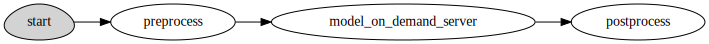

In [13]:
# Create the function:
serving_function = mlrun.code_to_function(
    name="model-on-demand-serving", 
    kind="serving", 
    image="mlrun/mlrun",
)

# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

# Build the serving graph:
graph.to(handler="preprocess", name="preprocess")\
     .to(class_name="ModelOnDemandServer", name="model_on_demand_server")\
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
graph.plot(rankdir='LR')

## Test Via Mock Server

In [14]:
# Create our server:
server = serving_function.to_mock_server()

In [15]:
# Setup the events:
tests = 5  # Amount of events to test
events =[{'models':models,'inputs': {"A": {"data": [{"ts": 1577836800.0, "val": 61.0}, {"ts": 1577837100.0, "val": 16.0}, {"ts": 1577837400.0, "val": 12.0}, {"ts": 1577837700.0, "val": 26.0}, {"ts": 1577838000.0, "val": 47.0}, {"ts": 1577838300.0, "val": 54.0}, {"ts": 1577838600.0, "val": 18.0}, {"ts": 1577838900.0, "val": 87.0}, {"ts": 1577839200.0, "val": 93.0}, {"ts": 1577839800.0, "val": 72.0}, {"ts": 1577840100.0, "val": 73.0}, {"ts": 1577840400.0, "val": 54.0}, {"ts": 1577840700.0, "val": 64.0}, {"ts": 1577841000.0, "val": 17.0}, {"ts": 1577841600.0, "val": 2.0}, {"ts": 1577841900.0, "val": 41.0}, {"ts": 1577842200.0, "val": 82.0}, {"ts": 1577842800.0, "val": 99.0}, {"ts": 1577843100.0, "val": 56.0}, {"ts": 1577843400.0, "val": 8.0}, {"ts": 1577843700.0, "val": 49.0}, {"ts": 1577844000.0, "val": 83.0}, {"ts": 1577844300.0, "val": 58.0}, {"ts": 1577844900.0, "val": 23.0}, {"ts": 1577845500.0, "val": 97.0}, {"ts": 1577845800.0, "val": 3.0}, {"ts": 1577846100.0, "val": 39.0}, {"ts": 1577846400.0, "val": 6.0}, {"ts": 1577846700.0, "val": 4.0}, {"ts": 1577847000.0, "val": 42.0}, {"ts": 1577847300.0, "val": 46.0}, {"ts": 1577847600.0, "val": 44.0}, {"ts": 1577848200.0, "val": 67.0}, {"ts": 1577848500.0, "val": 67.0}, {"ts": 1577848800.0, "val": 87.0}, {"ts": 1577849100.0, "val": 61.0}, {"ts": 1577849400.0, "val": 61.0}, {"ts": 1577849700.0, "val": 89.0}, {"ts": 1577850000.0, "val": 28.0}, {"ts": 1577850900.0, "val": 10.0}, {"ts": 1577851200.0, "val": 72.0}, {"ts": 1577851800.0, "val": 35.0}, {"ts": 1577852100.0, "val": 79.0}, {"ts": 1577852400.0, "val": 63.0}, {"ts": 1577852700.0, "val": 57.0}, {"ts": 1577853000.0, "val": 46.0}, {"ts": 1577853300.0, "val": 23.0}, {"ts": 1577853600.0, "val": 21.0}, {"ts": 1577853900.0, "val": 43.0}, {"ts": 1577854200.0, "val": 86.0}, {"ts": 1577854500.0, "val": 33.0}, {"ts": 1577854800.0, "val": 47.0}, {"ts": 1577855100.0, "val": 32.0}, {"ts": 1577855400.0, "val": 57.0}, {"ts": 1577856300.0, "val": 77.0}, {"ts": 1577856900.0, "val": 90.0}, {"ts": 1577857200.0, "val": 86.0}, {"ts": 1577857500.0, "val": 70.0}, {"ts": 1577857800.0, "val": 97.0}, {"ts": 1577858400.0, "val": 23.0}, {"ts": 1577859000.0, "val": 69.0}, {"ts": 1577859300.0, "val": 6.0}, {"ts": 1577859600.0, "val": 70.0}, {"ts": 1577860200.0, "val": 97.0}, {"ts": 1577860500.0, "val": 34.0}, {"ts": 1577860800.0, "val": 95.0}, {"ts": 1577861100.0, "val": 64.0}, {"ts": 1577861400.0, "val": 4.0}, {"ts": 1577861700.0, "val": 71.0}, {"ts": 1577862000.0, "val": 77.0}, {"ts": 1577862600.0, "val": 78.0}, {"ts": 1577862900.0, "val": 43.0}, {"ts": 1577863800.0, "val": 95.0}, {"ts": 1577864100.0, "val": 79.0}, {"ts": 1577864400.0, "val": 63.0}, {"ts": 1577865000.0, "val": 72.0}, {"ts": 1577865300.0, "val": 69.0}, {"ts": 1577865600.0, "val": 16.0}, {"ts": 1577865900.0, "val": 8.0}, {"ts": 1577866500.0, "val": 28.0}, {"ts": 1577866800.0, "val": 93.0}, {"ts": 1577867100.0, "val": 58.0}, {"ts": 1577867400.0, "val": 53.0}, {"ts": 1577868000.0, "val": 96.0}, {"ts": 1577868300.0, "val": 91.0}, {"ts": 1577868600.0, "val": 43.0}, {"ts": 1577868900.0, "val": 69.0}, {"ts": 1577869200.0, "val": 3.0}, {"ts": 1577869800.0, "val": 90.0}, {"ts": 1577870100.0, "val": 50.0}, {"ts": 1577870400.0, "val": 2.0}, {"ts": 1577871300.0, "val": 74.0}, {"ts": 1577871600.0, "val": 41.0}, {"ts": 1577871900.0, "val": 81.0}, {"ts": 1577872200.0, "val": 37.0}, {"ts": 1577872800.0, "val": 79.0}, {"ts": 1577873100.0, "val": 46.0}, {"ts": 1577873400.0, "val": 80.0}, {"ts": 1577873700.0, "val": 30.0}, {"ts": 1577874000.0, "val": 57.0}, {"ts": 1577874300.0, "val": 39.0}, {"ts": 1577874600.0, "val": 6.0}, {"ts": 1577874900.0, "val": 25.0}, {"ts": 1577875500.0, "val": 15.0}, {"ts": 1577876100.0, "val": 66.0}, {"ts": 1577876700.0, "val": 48.0}, {"ts": 1577877000.0, "val": 64.0}, {"ts": 1577877300.0, "val": 24.0}, {"ts": 1577877600.0, "val": 18.0}, {"ts": 1577877900.0, "val": 41.0}, {"ts": 1577878500.0, "val": 5.0}, {"ts": 1577878800.0, "val": 85.0}, {"ts": 1577879100.0, "val": 81.0}, {"ts": 1577879400.0, "val": 4.0}, {"ts": 1577880000.0, "val": 31.0}, {"ts": 1577880300.0, "val": 28.0}, {"ts": 1577880600.0, "val": 30.0}, {"ts": 1577880900.0, "val": 20.0}, {"ts": 1577881200.0, "val": 24.0}, {"ts": 1577881500.0, "val": 35.0}]}, "B": {"data": [{"ts": 1577837100.0, "val": 36.0}, {"ts": 1577837400.0, "val": 5.0}, {"ts": 1577837700.0, "val": 2.0}, {"ts": 1577838000.0, "val": 22.0}, {"ts": 1577838300.0, "val": 83.0}, {"ts": 1577838600.0, "val": 4.0}, {"ts": 1577838900.0, "val": 92.0}, {"ts": 1577839200.0, "val": 6.0}, {"ts": 1577839500.0, "val": 7.0}, {"ts": 1577839800.0, "val": 76.0}, {"ts": 1577840400.0, "val": 6.0}, {"ts": 1577840700.0, "val": 30.0}, {"ts": 1577841000.0, "val": 15.0}, {"ts": 1577841300.0, "val": 21.0}, {"ts": 1577841600.0, "val": 51.0}, {"ts": 1577841900.0, "val": 69.0}, {"ts": 1577842200.0, "val": 19.0}, {"ts": 1577842500.0, "val": 94.0}, {"ts": 1577842800.0, "val": 75.0}, {"ts": 1577843100.0, "val": 93.0}, {"ts": 1577843700.0, "val": 1.0}, {"ts": 1577844000.0, "val": 71.0}, {"ts": 1577844600.0, "val": 77.0}, {"ts": 1577844900.0, "val": 84.0}, {"ts": 1577845200.0, "val": 40.0}, {"ts": 1577845500.0, "val": 51.0}, {"ts": 1577845800.0, "val": 35.0}, {"ts": 1577846100.0, "val": 42.0}, {"ts": 1577846400.0, "val": 59.0}, {"ts": 1577847000.0, "val": 99.0}, {"ts": 1577847600.0, "val": 23.0}, {"ts": 1577847900.0, "val": 59.0}, {"ts": 1577848200.0, "val": 68.0}, {"ts": 1577848500.0, "val": 78.0}, {"ts": 1577849100.0, "val": 43.0}, {"ts": 1577849400.0, "val": 13.0}, {"ts": 1577850000.0, "val": 14.0}, {"ts": 1577850300.0, "val": 32.0}, {"ts": 1577850600.0, "val": 38.0}, {"ts": 1577850900.0, "val": 96.0}, {"ts": 1577851200.0, "val": 75.0}, {"ts": 1577851800.0, "val": 89.0}, {"ts": 1577852100.0, "val": 73.0}, {"ts": 1577852400.0, "val": 12.0}, {"ts": 1577852700.0, "val": 6.0}, {"ts": 1577853000.0, "val": 25.0}, {"ts": 1577853600.0, "val": 13.0}, {"ts": 1577853900.0, "val": 59.0}, {"ts": 1577854800.0, "val": 27.0}, {"ts": 1577855100.0, "val": 30.0}, {"ts": 1577855700.0, "val": 42.0}, {"ts": 1577856000.0, "val": 30.0}, {"ts": 1577856300.0, "val": 28.0}, {"ts": 1577856600.0, "val": 37.0}, {"ts": 1577857800.0, "val": 20.0}, {"ts": 1577858100.0, "val": 82.0}, {"ts": 1577858400.0, "val": 37.0}, {"ts": 1577858700.0, "val": 95.0}, {"ts": 1577859000.0, "val": 27.0}, {"ts": 1577859300.0, "val": 90.0}, {"ts": 1577859600.0, "val": 43.0}, {"ts": 1577859900.0, "val": 11.0}, {"ts": 1577860200.0, "val": 85.0}, {"ts": 1577860500.0, "val": 13.0}, {"ts": 1577861100.0, "val": 72.0}, {"ts": 1577861400.0, "val": 65.0}, {"ts": 1577861700.0, "val": 65.0}, {"ts": 1577862000.0, "val": 27.0}, {"ts": 1577862300.0, "val": 55.0}, {"ts": 1577862600.0, "val": 18.0}, {"ts": 1577863200.0, "val": 32.0}, {"ts": 1577863500.0, "val": 63.0}, {"ts": 1577863800.0, "val": 10.0}, {"ts": 1577864100.0, "val": 20.0}, {"ts": 1577864400.0, "val": 17.0}, {"ts": 1577864700.0, "val": 65.0}, {"ts": 1577865000.0, "val": 21.0}, {"ts": 1577865300.0, "val": 66.0}, {"ts": 1577865600.0, "val": 95.0}, {"ts": 1577865900.0, "val": 37.0}, {"ts": 1577866200.0, "val": 50.0}, {"ts": 1577866500.0, "val": 14.0}, {"ts": 1577867100.0, "val": 1.0}, {"ts": 1577867400.0, "val": 26.0}, {"ts": 1577867700.0, "val": 45.0}, {"ts": 1577868000.0, "val": 29.0}, {"ts": 1577868300.0, "val": 94.0}, {"ts": 1577868600.0, "val": 85.0}, {"ts": 1577868900.0, "val": 65.0}, {"ts": 1577869200.0, "val": 13.0}, {"ts": 1577869800.0, "val": 53.0}, {"ts": 1577870100.0, "val": 82.0}, {"ts": 1577870400.0, "val": 14.0}, {"ts": 1577870700.0, "val": 47.0}, {"ts": 1577871000.0, "val": 55.0}, {"ts": 1577871300.0, "val": 1.0}, {"ts": 1577871600.0, "val": 28.0}, {"ts": 1577871900.0, "val": 67.0}, {"ts": 1577873100.0, "val": 20.0}, {"ts": 1577873400.0, "val": 57.0}, {"ts": 1577873700.0, "val": 41.0}, {"ts": 1577874000.0, "val": 44.0}, {"ts": 1577874300.0, "val": 78.0}, {"ts": 1577874600.0, "val": 4.0}, {"ts": 1577874900.0, "val": 60.0}, {"ts": 1577875500.0, "val": 34.0}, {"ts": 1577876100.0, "val": 32.0}, {"ts": 1577876400.0, "val": 84.0}, {"ts": 1577877300.0, "val": 24.0}, {"ts": 1577877600.0, "val": 96.0}, {"ts": 1577878200.0, "val": 32.0}, {"ts": 1577878500.0, "val": 64.0}, {"ts": 1577878800.0, "val": 56.0}, {"ts": 1577879100.0, "val": 84.0}, {"ts": 1577879400.0, "val": 49.0}, {"ts": 1577879700.0, "val": 6.0}, {"ts": 1577880300.0, "val": 73.0}, {"ts": 1577880900.0, "val": 60.0}, {"ts": 1577881200.0, "val": 27.0}, {"ts": 1577881500.0, "val": 0.0}]}, "C": {"data": [{"ts": 1577837100.0, "val": 53.0}, {"ts": 1577837400.0, "val": 32.0}, {"ts": 1577837700.0, "val": 66.0}, {"ts": 1577838000.0, "val": 63.0}, {"ts": 1577838300.0, "val": 45.0}, {"ts": 1577838600.0, "val": 91.0}, {"ts": 1577838900.0, "val": 40.0}, {"ts": 1577839500.0, "val": 76.0}, {"ts": 1577839800.0, "val": 69.0}, {"ts": 1577840100.0, "val": 66.0}, {"ts": 1577840700.0, "val": 44.0}, {"ts": 1577841000.0, "val": 13.0}, {"ts": 1577841300.0, "val": 23.0}, {"ts": 1577841600.0, "val": 28.0}, {"ts": 1577841900.0, "val": 46.0}, {"ts": 1577842200.0, "val": 54.0}, {"ts": 1577842500.0, "val": 75.0}, {"ts": 1577842800.0, "val": 90.0}, {"ts": 1577843100.0, "val": 35.0}, {"ts": 1577843700.0, "val": 39.0}, {"ts": 1577844000.0, "val": 72.0}, {"ts": 1577844300.0, "val": 92.0}, {"ts": 1577845500.0, "val": 17.0}, {"ts": 1577845800.0, "val": 84.0}, {"ts": 1577846100.0, "val": 9.0}, {"ts": 1577846400.0, "val": 73.0}, {"ts": 1577846700.0, "val": 29.0}, {"ts": 1577847300.0, "val": 12.0}, {"ts": 1577847600.0, "val": 12.0}, {"ts": 1577847900.0, "val": 66.0}, {"ts": 1577848500.0, "val": 86.0}, {"ts": 1577849100.0, "val": 11.0}, {"ts": 1577849400.0, "val": 72.0}, {"ts": 1577849700.0, "val": 6.0}, {"ts": 1577850000.0, "val": 99.0}, {"ts": 1577850600.0, "val": 52.0}, {"ts": 1577850900.0, "val": 41.0}, {"ts": 1577851200.0, "val": 10.0}, {"ts": 1577851500.0, "val": 93.0}, {"ts": 1577851800.0, "val": 85.0}, {"ts": 1577852100.0, "val": 7.0}, {"ts": 1577852700.0, "val": 19.0}, {"ts": 1577853000.0, "val": 74.0}, {"ts": 1577853600.0, "val": 24.0}, {"ts": 1577853900.0, "val": 42.0}, {"ts": 1577854200.0, "val": 28.0}, {"ts": 1577854500.0, "val": 69.0}, {"ts": 1577854800.0, "val": 85.0}, {"ts": 1577855100.0, "val": 1.0}, {"ts": 1577855400.0, "val": 91.0}, {"ts": 1577855700.0, "val": 55.0}, {"ts": 1577856000.0, "val": 67.0}, {"ts": 1577856300.0, "val": 75.0}, {"ts": 1577856600.0, "val": 21.0}, {"ts": 1577856900.0, "val": 33.0}, {"ts": 1577857200.0, "val": 93.0}, {"ts": 1577857500.0, "val": 16.0}, {"ts": 1577858100.0, "val": 91.0}, {"ts": 1577858700.0, "val": 63.0}, {"ts": 1577859000.0, "val": 63.0}, {"ts": 1577859300.0, "val": 33.0}, {"ts": 1577859900.0, "val": 7.0}, {"ts": 1577860200.0, "val": 68.0}, {"ts": 1577860500.0, "val": 71.0}, {"ts": 1577860800.0, "val": 61.0}, {"ts": 1577861400.0, "val": 82.0}, {"ts": 1577861700.0, "val": 51.0}, {"ts": 1577862000.0, "val": 62.0}, {"ts": 1577862300.0, "val": 17.0}, {"ts": 1577862600.0, "val": 14.0}, {"ts": 1577862900.0, "val": 78.0}, {"ts": 1577863500.0, "val": 31.0}, {"ts": 1577863800.0, "val": 30.0}, {"ts": 1577864400.0, "val": 73.0}, {"ts": 1577864700.0, "val": 34.0}, {"ts": 1577865000.0, "val": 22.0}, {"ts": 1577865300.0, "val": 60.0}, {"ts": 1577865600.0, "val": 17.0}, {"ts": 1577865900.0, "val": 78.0}, {"ts": 1577866200.0, "val": 65.0}, {"ts": 1577866500.0, "val": 98.0}, {"ts": 1577866800.0, "val": 10.0}, {"ts": 1577867700.0, "val": 58.0}, {"ts": 1577868000.0, "val": 75.0}, {"ts": 1577868300.0, "val": 70.0}, {"ts": 1577868900.0, "val": 71.0}, {"ts": 1577869200.0, "val": 90.0}, {"ts": 1577869800.0, "val": 32.0}, {"ts": 1577870100.0, "val": 63.0}, {"ts": 1577870400.0, "val": 94.0}, {"ts": 1577870700.0, "val": 96.0}, {"ts": 1577871300.0, "val": 86.0}, {"ts": 1577871600.0, "val": 12.0}, {"ts": 1577871900.0, "val": 13.0}, {"ts": 1577872200.0, "val": 14.0}, {"ts": 1577872500.0, "val": 84.0}, {"ts": 1577873400.0, "val": 4.0}, {"ts": 1577873700.0, "val": 72.0}, {"ts": 1577874300.0, "val": 3.0}, {"ts": 1577874600.0, "val": 45.0}, {"ts": 1577875200.0, "val": 89.0}, {"ts": 1577875500.0, "val": 48.0}, {"ts": 1577875800.0, "val": 76.0}, {"ts": 1577876100.0, "val": 37.0}, {"ts": 1577876400.0, "val": 53.0}, {"ts": 1577876700.0, "val": 45.0}, {"ts": 1577877000.0, "val": 3.0}, {"ts": 1577877300.0, "val": 85.0}, {"ts": 1577877600.0, "val": 11.0}, {"ts": 1577877900.0, "val": 82.0}, {"ts": 1577878800.0, "val": 72.0}, {"ts": 1577879100.0, "val": 58.0}, {"ts": 1577879400.0, "val": 34.0}, {"ts": 1577879700.0, "val": 64.0}, {"ts": 1577880000.0, "val": 45.0}, {"ts": 1577880300.0, "val": 48.0}, {"ts": 1577880600.0, "val": 90.0}, {"ts": 1577880900.0, "val": 89.0}, {"ts": 1577881200.0, "val": 58.0}, {"ts": 1577881500.0, "val": 79.0}]}}}]
response = server.test(path='/predict', body={'inputs':events})
print(f"Response: {response}")
print()

Loading model...
Predicting...
Predicted:
{"A": {"data": [{"ts": 1577842800.0, "val": -75.22700500488281}, {"ts": 1577843100.0, "val": -33.278568267822266}, {"ts": 1577843400.0, "val": -14.420534133911133}, {"ts": 1577843700.0, "val": -36.39292907714844}, {"ts": 1577844000.0, "val": -61.182106018066406}, {"ts": 1577844300.0, "val": -60.179298400878906}, {"ts": 1577844600.0, "val": -59.911865234375}, {"ts": 1577844900.0, "val": -45.84920883178711}, {"ts": 1577845200.0, "val": -47.81039810180664}, {"ts": 1577845500.0, "val": -43.321346282958984}, {"ts": 1577845800.0, "val": -36.64811325073242}, {"ts": 1577846100.0, "val": -17.4080753326416}, {"ts": 1577846400.0, "val": -31.906505584716797}, {"ts": 1577846700.0, "val": -11.71877384185791}, {"ts": 1577847000.0, "val": -24.865148544311523}, {"ts": 1577847300.0, "val": -18.940431594848633}, {"ts": 1577847600.0, "val": -21.542192459106445}, {"ts": 1577847900.0, "val": -43.74910354614258}, {"ts": 1577848200.0, "val": -52.38409423828125}, {"ts"

## Deploy

In [12]:
# Mount it:
serving_function.apply(mlrun.platforms.auto_mount())

# Deploy it:
serving_function.deploy()

> 2022-05-19 14:49:43,531 [info] Starting remote function deploy
2022-05-19 14:49:43  (info) Deploying function
2022-05-19 14:49:43  (info) Building
2022-05-19 14:49:43  (info) Staging files and preparing base images
2022-05-19 14:49:44  (info) Building processor image
2022-05-19 14:51:59  (info) Build complete
2022-05-19 14:52:11  (info) Function deploy complete
> 2022-05-19 14:52:12,104 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-model-on-demand-guyl-model-on-demand-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['model-on-demand-guyl-model-on-demand-serving-model-on-jcpkt3es.default-tenant.app.yh43.iguazio-cd1.com/']}


'http://model-on-demand-guyl-model-on-demand-serving-model-on-jcpkt3es.default-tenant.app.yh43.iguazio-cd1.com/'

In [13]:
# Setup the events:
tests = 5  # Amount of events to test
events = [
    {
        EventKeys.MODEL_NAME: list(models.keys())[model],
        EventKeys.MODEL_UID: list(models.values())[model],
        EventKeys.INPUTS: np.random.random((3,5)).tolist()
    } for model in np.random.randint(len(models), size=tests)
]

# Run the events thorugh the serving graph:
for i, event in enumerate(events, 1):
    print(f"Test {i}:")
    response = serving_function.invoke(path='/predict', body=event)
    print(f"Response: {response}")
    print()

Test 1:
> 2022-05-19 14:52:12,154 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-model-on-demand-guyl-model-on-demand-serving.default-tenant.svc.cluster.local:8080/predict'}
Response: {'prediction': [0, 1, 1], 'probability': [0.6582490479640303, 0.8292301745846826, 0.8033226006396991]}

Test 2:
> 2022-05-19 14:52:13,722 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-model-on-demand-guyl-model-on-demand-serving.default-tenant.svc.cluster.local:8080/predict'}
Response: {'prediction': [0, 1, 1], 'probability': [0.5, 0.51, 0.51]}

Test 3:
> 2022-05-19 14:52:13,922 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-model-on-demand-guyl-model-on-demand-serving.default-tenant.svc.cluster.local:8080/predict'}
Response: {'prediction': [1, 1, 1], 'probability': [0.6157039686116867, 0.6714062044217334, 0.8127560705320326]}

Test 4:
> 2022-05-19 14:52:14,078 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-model-on-deman